In [3]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [5]:
levels = spark.read.json("../data/all_levels_20210801.json", multiLine=True).cache()
levels.printSchema()
levels.show(n=5)

root
 |-- level: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

+-----+-------+-------------------+
|level|   name|          timestamp|
+-----+-------+-------------------+
|  200|Unlucky|2016-08-07 16:27:09|
|  199|Unlucky|2016-07-24 12:45:27|
|  198|Unlucky|2016-07-14 07:50:14|
|  197|Unlucky|2016-06-24 00:51:22|
|  196|Unlucky|2016-06-09 07:10:15|
+-----+-------+-------------------+
only showing top 5 rows



In [6]:
ranking = spark.read.json("../data/all_ranking_20210731_deduped.json", multiLine=True).cache()
ranking.printSchema()
ranking.show(n=5)

root
 |-- fame: long (nullable = true)
 |-- guild: string (nullable = true)
 |-- job: string (nullable = true)
 |-- level: long (nullable = true)
 |-- mastery: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- specialization: string (nullable = true)

+----+-------+--------+-----+----------+--------+----+--------------+
|fame|  guild|     job|level|   mastery|    name|rank|specialization|
+----+-------+--------+-----+----------+--------+----+--------------+
| 420|Project|magician|  200|    bishop| Unlucky|   1|        cleric|
|2714|   Noir|   thief|  200|night lord|    Babo|   2|      assassin|
| 784|   Noir|   thief|  200|night lord|    Nude|   3|      assassin|
|1135|   Noir|magician|  200|    bishop| JayChou|   4|        cleric|
| 263|Project|  bowman|  200| bowmaster|Zeretius|   5|        hunter|
+----+-------+--------+-----+----------+--------+----+--------------+
only showing top 5 rows



In [10]:
levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")

exptable = spark.read.csv("../data/exptable.csv", header=True, inferSchema=True).cache()
exptable.createOrReplaceTempView("exptable")

In [8]:
spark.sql("select count(distinct name) from ranking").show()
spark.sql("select count(distinct name) from levels").show()

+--------------------+
|count(DISTINCT name)|
+--------------------+
|              201514|
+--------------------+

+--------------------+
|count(DISTINCT name)|
+--------------------+
|              201499|
+--------------------+



In [14]:
spark.sql("""
select distinct
    job,
    mastery
from ranking
where specialization = "all"
""").show()

+--------+--------+
|     job| mastery|
+--------+--------+
|   thief|   thief|
|  pirate|  pirate|
|magician|magician|
|  bowman|  bowman|
|beginner|beginner|
| warrior| warrior|
+--------+--------+



In [13]:
spark.sql("""
select 
    specialization,
    count(distinct name) as n
from ranking
group by 1
order by 2 desc
""").show()

+--------------+------+
|specialization|     n|
+--------------+------+
|           all|123373|
|        cleric| 18626|
|      assassin| 11862|
|      spearman|  9522|
|           ice|  8393|
|        bandit|  6013|
|        hunter|  5087|
|       fighter|  4477|
|          fire|  4137|
|       brawler|  3879|
|    gunslinger|  2335|
|          page|  2008|
|   crossbowman|  1802|
+--------------+------+



In [27]:
spark.sql("""
select 
    job,
    count(distinct name) as n
from ranking
group by 1
order by 2 desc
""").show()

+--------+-----+
|     job|    n|
+--------+-----+
|magician|53214|
|beginner|45021|
| warrior|39162|
|   thief|34375|
|  bowman|16185|
|  pirate|13557|
+--------+-----+



In [48]:
pdf = spark.sql("""
select 
    date_trunc("day", from_utc_timestamp(timestamp, "Z")) as date,
    count(*) as n
from levels
where level = 2
group by 1
order by 1
""").toPandas()
pdf

,date,n
0,2015-10-14,50
1,2015-10-15,43
2,2015-10-16,28
3,2015-10-17,43
4,2015-10-18,44
...,...,...
2100,2021-07-29,103
2101,2021-07-30,99
2102,2021-07-31,126
2103,2021-08-01,72


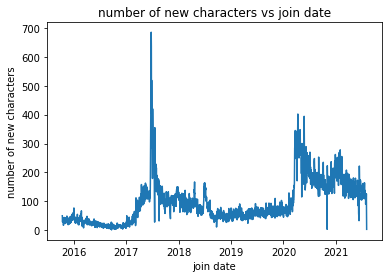

In [49]:
plt.plot(pdf.date, pdf.n)
plt.title("number of new characters vs join date")
plt.ylabel("number of new characters")
plt.xlabel("join date")
plt.show()

In [56]:
pdf = spark.sql("""
select 
    date_trunc("month", from_utc_timestamp(timestamp, "Z")) as date,
    count(*) as n
from levels
where level = 2
group by 1
order by 1
""").toPandas()
pdf

,date,n
0,2015-10-01,627
1,2015-11-01,1041
2,2015-12-01,1202
3,2016-01-01,1234
4,2016-02-01,1057
...,...,...
66,2021-04-01,4372
67,2021-05-01,4479
68,2021-06-01,3684
69,2021-07-01,4028


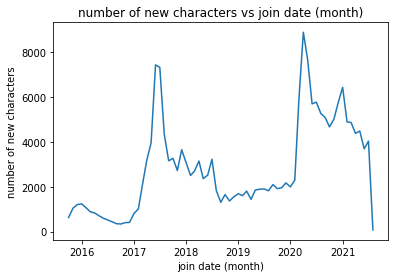

In [58]:
plt.plot(pdf.date, pdf.n)
plt.title("number of new characters vs join date (month)")
plt.ylabel("number of new characters")
plt.xlabel("join date (month)")
plt.show()

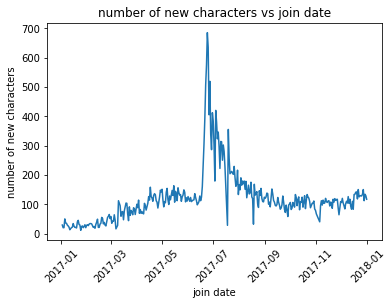

In [55]:
sub = pdf[(pdf.date > "2017")&(pdf.date < "2018")]
plt.plot(sub.date, sub.n)
plt.title("number of new characters vs join date")
plt.ylabel("number of new characters")
plt.xlabel("join date")
plt.xticks(rotation=45)
plt.show()

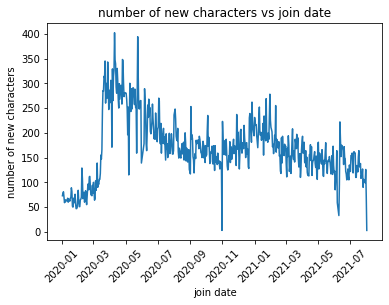

In [54]:
sub = pdf[pdf.date > "2020"]
plt.plot(sub.date, sub.n)
plt.title("number of new characters vs join date")
plt.ylabel("number of new characters")
plt.xlabel("join date")
plt.xticks(rotation=45)
plt.show()

In [ ]:
pdf = spark.sql("""
with names as (
    select distinct name
    from levels
    where level >= 30
)
select 
    date_trunc("day", from_utc_timestamp(timestamp, "Z")) as date,
    count(*) as n
from levels
right join names
using (name)
where level = 2
group by 1
order by 1
""").toPandas()

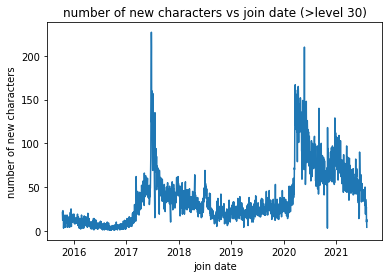

In [47]:
plt.plot(pdf.date, pdf.n)
plt.title("number of new characters vs join date (>level 30)")
plt.ylabel("number of new characters")
plt.xlabel("join date")
plt.show()

In [29]:
df = spark.sql("""
    with job as (
        select distinct name, job
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            job,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join job
        using (name)
    ),
    quantiles as (
        select distinct
            job,
            level,
            count(*) over (partition by level, job) as n,
            (min(diff) over (partition by level, job))/60 as p00,
            (percentile_approx(diff, 0.01) over (partition by level, job))/60 as p01,
            (percentile_approx(diff, 0.05) over (partition by level, job))/60 as p05,
            (percentile_approx(diff, 0.1) over (partition by level, job))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, job))/60 as p50
        from ttl
        where diff is not null
        order by 1, 2
    )
    select
        *,
        exp/p00 as epm_p00,
        exp/p01 as epm_p01,
        exp/p05 as epm_p05,
        exp/p10 as epm_p10,
        exp/p50 as epm_p50
    from quantiles
    join exptable
    using (level)
    order by job, level
""")
df.show(vertical=True, n=2)

-RECORD 0------------------------------
 level          | 2                    
 job            | beginner             
 n              | 1                    
 p00            | 94530.76666666666    
 p01            | 94530.76666666666    
 p05            | 94530.76666666666    
 p10            | 94530.76666666666    
 p50            | 94530.76666666666    
 exp            | 34                   
 cumulative_exp | 15                   
 epm_p00        | 3.596712604679323E-4 
 epm_p01        | 3.596712604679323E-4 
 epm_p05        | 3.596712604679323E-4 
 epm_p10        | 3.596712604679323E-4 
 epm_p50        | 3.596712604679323E-4 
-RECORD 1------------------------------
 level          | 3                    
 job            | beginner             
 n              | 42074                
 p00            | -94528.51666666666   
 p01            | 0.25                 
 p05            | 0.43333333333333335  
 p10            | 0.55                 
 p50            | 1.6                  


In [30]:
pdf = df.toPandas()

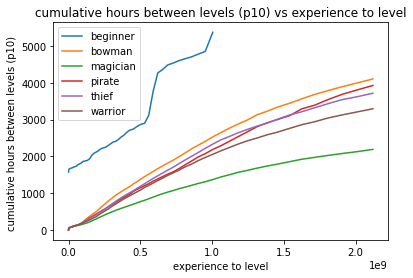

In [31]:
for name in pdf.job.unique():
    if name == "all":
        continue
    res = pdf[(pdf.job == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.exp, res.p10.cumsum()/60, label=f"{name}")
plt.title("cumulative hours between levels (p10) vs experience to level")
plt.xlabel("experience to level")
plt.ylabel("cumulative hours between levels (p10) ")
plt.legend(loc="upper left")
plt.show()

In [59]:
df = spark.sql("""
    with specialization as (
        select distinct name, specialization
        from ranking
    ),
    ttl as (
        select
            name,
            level,
            specialization,
            unix_timestamp(from_utc_timestamp(timestamp, "Z"))
                - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
                as diff
        from levels
        join specialization
        using (name)
    ),
    quantiles as (
        select distinct
            specialization,
            level,
            count(*) over (partition by level, specialization) as n,
            (min(diff) over (partition by level, specialization))/60 as p00,
            (percentile_approx(diff, 0.01) over (partition by level, specialization))/60 as p01,
            (percentile_approx(diff, 0.05) over (partition by level, specialization))/60 as p05,
            (percentile_approx(diff, 0.1) over (partition by level, specialization))/60 as p10,
            (percentile_approx(diff, 0.5) over (partition by level, specialization))/60 as p50
        from ttl
        where diff is not null
        order by 1, 2
    )
    select
        *,
        exp/p00 as epm_p00,
        exp/p01 as epm_p01,
        exp/p05 as epm_p05,
        exp/p10 as epm_p10,
        exp/p50 as epm_p50
    from quantiles
    join exptable
    using (level)
    order by specialization, level
""")
df.show(vertical=True, n=2)

-RECORD 0------------------------------
 level          | 2                    
 specialization | all                  
 n              | 1                    
 p00            | 94530.76666666666    
 p01            | 94530.76666666666    
 p05            | 94530.76666666666    
 p10            | 94530.76666666666    
 p50            | 94530.76666666666    
 exp            | 34                   
 cumulative_exp | 15                   
 epm_p00        | 3.596712604679323E-4 
 epm_p01        | 3.596712604679323E-4 
 epm_p05        | 3.596712604679323E-4 
 epm_p10        | 3.596712604679323E-4 
 epm_p50        | 3.596712604679323E-4 
-RECORD 1------------------------------
 level          | 3                    
 specialization | all                  
 n              | 119976               
 p00            | -94528.51666666666   
 p01            | 0.2833333333333333   
 p05            | 0.45                 
 p10            | 0.55                 
 p50            | 1.55                 


In [60]:
pdf = df.toPandas()

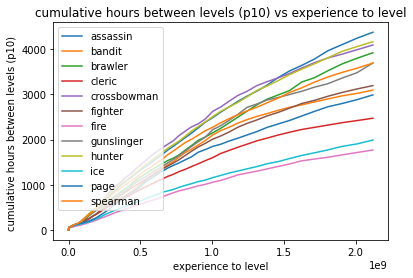

In [61]:
for name in pdf.specialization.unique():
    if name == "all":
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.exp, res.p10.cumsum()/60, label=f"{name}")
plt.title("cumulative hours between levels (p10) vs experience to level")
plt.xlabel("experience to level")
plt.ylabel("cumulative hours between levels (p10) ")
plt.legend(loc="upper left")
plt.show()

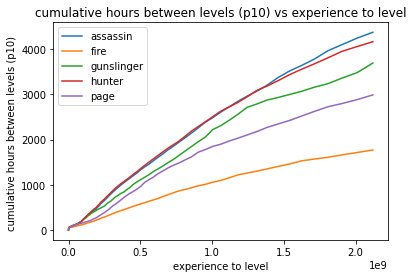

In [67]:
for name in pdf.specialization.unique():
    if name not in ("page", "assassin", "gunslinger", "hunter", "fire"):
        continue
    res = pdf[(pdf.specialization == name)]
    n = res[res.level == res.level.max()].n.values[0]
    plt.plot(res.exp, res.p10.cumsum()/60, label=f"{name}")
plt.title("cumulative hours between levels (p10) vs experience to level")
plt.xlabel("experience to level")
plt.ylabel("cumulative hours between levels (p10) ")
plt.legend(loc="upper left")
plt.show()